In [1]:
%load_ext autoreload
%autoreload 2

In [270]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.utils import class_weight

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions
from src.models import model_mine
from src.submission import generate_predictions

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [149]:
(X_train, y_train), _, (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 128338.14it/s]


In [150]:
X_train.shape, X_train.values.shape

((30160,), (30160,))

### Compute the classes weights because our dataset is largely unbalanced

In [118]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

### Create an embedding matrix for our vocabulary

In [224]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
# Unknown words: 1303

print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

8.84% of our vocabulary are unknown words to the embedding matrix


### Spellcheck testing

In [193]:
from autocorrect import spell

In [195]:
l_unkown = list(unknown_words.keys())

In [196]:
from multiprocessing import Pool

def spellcheck(word):
    return word, spell(word)

with Pool(processes=6) as pool:
    res = list(pool.map(spellcheck, l_unkown))
    corr_2 = {k: v for (k,v) in res}

In [200]:
emb_dict = get_embedding_dictionnary(embeddings_path)

In [226]:
still_unknown = defaultdict(int)

for word, correction in corr_2.items():
    correction = correction.lower()
    if len(word) > 2 and word != correction:
        index = word_index[word]
        if correction in emb_dict:
            emb_matrix[index] = emb_dict[correction]
        elif correction in word_index:
            print(f'{correction} (from {word}) in word_index')
        else:
            still_unknown[(word, correction)] += 1
    else:
        still_unknown[(word, correction)] += 1

len(still_unknown)

535

### Transforming our sequences of words to indexes

In [151]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)

X_train.shape

(30160, 163)

In [152]:
y_train = to_categorical(y_train, 4)
(x_trn, y_trn), (x_val, y_val), (x_tst, y_tst) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')
print('validation_test set: ' + str(len(x_tst)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 24128 samples
validation set: 3016 samples
validation_test set: 3016 samples
x_train: (24128, 163)
y_train: (24128, 4)


### Training

In [227]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 163, 300)          4424400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 163, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_11 (Dropout)         (None, 163, 300)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_12 (Dropout)         (None, 163, 300)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48900)             0         
__________

In [228]:
checkpointer = ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1)

In [229]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=3, class_weight=cls_weights, callbacks=[checkpointer])

Train on 24128 samples, validate on 3016 samples
Epoch 1/3
24128/24128 [==============================] - 431s 18ms/step - loss: 0.7477 - acc: 0.7086 - val_loss: 0.5180 - val_acc: 0.8031

Epoch 00001: val_loss improved from inf to 0.51801, saving model to pickles/models/best.h5
Epoch 2/3
24128/24128 [==============================] - 421s 17ms/step - loss: 0.4909 - acc: 0.8176 - val_loss: 0.4264 - val_acc: 0.8515

Epoch 00002: val_loss improved from 0.51801 to 0.42639, saving model to pickles/models/best.h5
Epoch 3/3
24128/24128 [==============================] - 418s 17ms/step - loss: 0.4132 - acc: 0.8507 - val_loss: 0.3787 - val_acc: 0.8581

Epoch 00003: val_loss improved from 0.42639 to 0.37867, saving model to pickles/models/best.h5


In [ ]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=6, class_weight=cls_weights, callbacks=[checkpointer])

Train on 24128 samples, validate on 3016 samples
Epoch 1/6
24128/24128 [==============================] - 422s 17ms/step - loss: 0.3567 - acc: 0.8693 - val_loss: 0.3294 - val_acc: 0.8863

Epoch 00001: val_loss improved from 0.37867 to 0.32939, saving model to pickles/models/best.h5
Epoch 2/6
17280/24128 [====================>.........] - ETA: 1:52 - loss: 0.3109 - acc: 0.8858

### Evaluating our model

In [271]:
model = load_model('pickles/models/best.h5')

#### Validation set

True Positives per class :  [ 478.  368.  466. 1380.]
False Positives per class :  [ 69.  52.  40. 163.]
False Negatives per class :  [ 80.  67.  73. 104.]

Class angry : Precision : 0.874, Recall : 0.857, F1 : 0.865
Class happy : Precision : 0.876, Recall : 0.846, F1 : 0.861
Class sad : Precision : 0.921, Recall : 0.865, F1 : 0.892

Ignoring the Others class, Macro Precision : 0.8903, Macro Recall : 0.8557, Macro F1 : 0.8727
Ignoring the Others class, Micro TP : 1312, FP : 161, FN : 220

Accuracy : 0.8926, Micro Precision : 0.8907, Micro Recall : 0.8564, Micro F1 : 0.8732


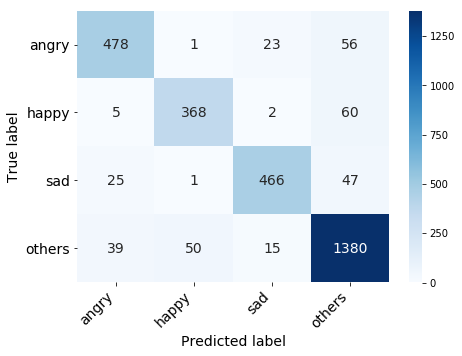

In [272]:
y_pred_val = get_predictions(model, x_val, y_val) # Last Best

#### Test set

True Positives per class :  [ 474.  379.  492. 1356.]
False Positives per class :  [ 59.  56.  47. 153.]
False Negatives per class :  [ 70.  63.  59. 123.]

Class angry : Precision : 0.889, Recall : 0.871, F1 : 0.880
Class happy : Precision : 0.871, Recall : 0.857, F1 : 0.864
Class sad : Precision : 0.913, Recall : 0.893, F1 : 0.903

Ignoring the Others class, Macro Precision : 0.8911, Macro Recall : 0.8739, Macro F1 : 0.8824
Ignoring the Others class, Micro TP : 1345, FP : 162, FN : 192

Accuracy : 0.8956, Micro Precision : 0.8925, Micro Recall : 0.8751, Micro F1 : 0.8837


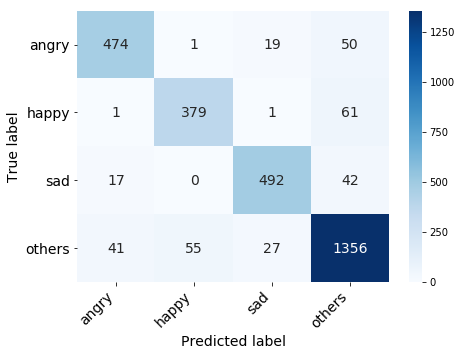

In [273]:
y_pred_tst = get_predictions(model, x_tst, y_tst) # Last Best

In [276]:
model.save('pickles/models/val_acc_0.88-tst_f1_0.883-res_f1_?.h5')

### Generating a submission file

In [277]:
generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:01<00:00, 2435.72it/s]


Generating Predictions...
Done. Wrote submission.txt file at project's root
